In [2]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.filters import frangi
from PIL import Image, ImageOps, ImageFilter, ImageChops
import matplotlib.cm as cm
from skimage.filters import threshold_otsu

# Code for refining the box once img is loaded

In [5]:
def normalize(img_):
    return (img_-np.min(img_))/(np.max(img_)-np.min(img_))

def gaussian_kernel(size, sigma):
    """Creates a Gaussian kernel with the given size and sigma"""
    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(-size//2+1, size//2+1))
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

def gaussian_filter(img_, k_size=3, sigma=1):
    """Applies a Gaussian filter to the given image"""
    kernel = gaussian_kernel(k_size, sigma)
    smoothed = convolve(img_, kernel)
    return smoothed

def refine_label_gaussian(img_, k_size=3, sigma=1, thsld=0.5, use_otsu=True):
    img_smooth = gaussian_filter(img_, k_size, sigma)
    if use_otsu:
        thresh = threshold_otsu(img)
        binary = img < thresh
        return binary
    else:
        return img_smooth < thsld

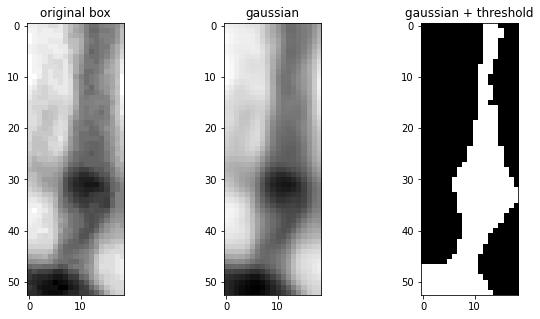

In [6]:
dataset_path = '../data/image_dir'
train_labels = pd.read_csv('../original_data/train_labels.csv')
test_labels = pd.read_csv('../original_data/test_labels.csv')

k = 20 #we access the k-th bounding box
file = train_labels["filename"][k]

img_full = np.sum(np.array(Image.open(os.path.join(dataset_path, file))), axis = 2)
xmin = train_labels.iloc[k,4]
xmax = train_labels.iloc[k,6]
ymin = train_labels.iloc[k,5]
ymax = train_labels.iloc[k,7]

#img contains the bounding box we want to refine
img = img_full.T[xmin : xmax, ymin : ymax] #we have to transpose in order to match the coordinate system
img = normalize(img)

#parameters that can be modified to enhance the refined label
k_size = 3
sigma = 1
thsld = 0.5
use_otsu = False
# frangi_thresold = 0.5
# otsu = False #set True if you want touse otsu thresholding instead of thsld 

#compute the refined label
refined1 = gaussian_filter(img, k_size, sigma)
refined2 = refine_label_gaussian(img, k_size, sigma, thsld, use_otsu)
# refined3 = (refined1 + refined2) >= 1

#visualize if the label is adapted what we want
fig,axs = plt.subplots(1, 3, figsize = (10,5))
axs[0].imshow(img, cmap=cm.gray)
axs[0].set_title("original box")
axs[1].imshow(refined1, cmap=cm.gray)
axs[1].set_title("gaussian")
axs[2].set_title("gaussian + threshold")
axs[2].imshow(refined2, cmap=cm.gray)

# Apply refine filter, concat raw/mask and save image

In [8]:
refined_path = '../original_data/refined_labels/'
num_train = len(train_labels["filename"])
print(f"num of bbox = {num_train}")

save_refined = True

if save_refined:
    print(f"Save refined segmentation of bbox (N = {num_train})")
    
    for k in range(num_train):
        file = train_labels["filename"][k]

        img_full = np.sum(np.array(Image.open(os.path.join(dataset_path, file))), axis = 2)
        xmin = train_labels.iloc[k,4]
        xmax = train_labels.iloc[k,6]
        ymin = train_labels.iloc[k,5]
        ymax = train_labels.iloc[k,7]

        #img contains the bounding box we want to refine
        img = img_full.T[xmin : xmax, ymin : ymax] #we have to transpose in order to match the coordinate system
        img = normalize(img)

        #compute the refined label
        refined = refine_label_gaussian(img, k_size, sigma, thsld, use_otsu)

        # raw and refined images are concatenated and saved into one image
        # image saved in gray scale since raw is gray (though mask is binary)
        merged = np.concatenate((img, refined), axis=1)
        plt.imsave(refined_path + f'merged{k}.png', merged, cmap=cm.gray)

num of bbox = 7493
Save refined segmentation of bbox (N = 7493)


# Manual inspection by user
* quickly check the mask and select that looks good
* remove bad quality mask, e.g. discontinuous vessle, noisy image, etc
* After selection, 4834 images+mask were selected

# Split selected images into img and mask (resize vs pad)
* U-Net requires uniform size of all the images. 
* B-box size is not uniform, so need to make the uniform
    * Method1: resize
    * Method2: zero padding

Text(0.5, 1.0, 'img_6027_mask')

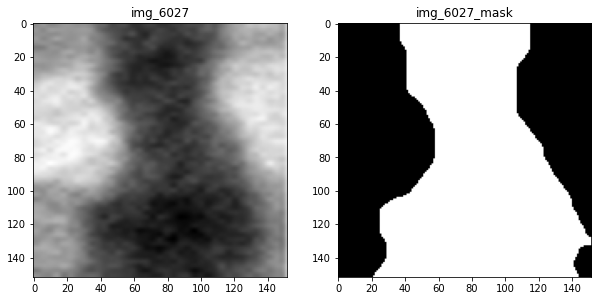

In [124]:
target_size = (152*2, 152)

selected_path = '../original_data/refined_labels_selected/'
img_path = '../original_data/refined_labels_selected_split/imgs/'
mask_path = '../original_data/refined_labels_selected_split/masks/'

files = os.listdir(selected_path)
file = files[60]
index = file[6:-4] # original bmp file number    

image = Image.open(os.path.join(selected_path, file))       
resized_image = image.resize(target_size)
image.close()

# Get the dimensions of the image
width, height = resized_image.size

# Calculate the coordinates for cutting the image in half
left, top, right, bottom = 0, 0, width//2, height

# Crop the left half of the image
left_half = resized_image.crop((left, top, right, bottom)).convert('RGB')

# Calculate the coordinates for the right half of the image
left, right = width // 2, width

# Crop the right half of the image
right_half = resized_image.crop((left, top, right, bottom))

# Invert and conver to binary
right_half = 256 - np.array(right_half)[:, :, 0]
right_half = refine_label_gaussian(right_half, k_size=7, sigma=7, thsld=128, use_otsu=False)
right_half = Image.fromarray(right_half)

#visualize if the label is adapted what we want
fig,axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].imshow(left_half, cmap=cm.gray)
axs[0].set_title(f"img_{index}")
axs[1].imshow(right_half, cmap=cm.binary)
axs[1].set_title(f"img_{index}_mask")


Text(0.5, 1.0, 'img_1408_mask')

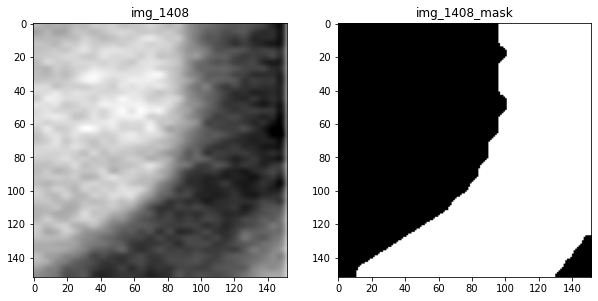

In [125]:
save_result = False

selected_path = '../original_data/refined_labels_selected/'
img_path = '../original_data/refined_labels_selected_split/imgs/'
mask_path = '../original_data/refined_labels_selected_split/masks/'

target_size = (152*2, 152)

files = os.listdir(selected_path)

for file in files:
    index = file[6:-4] # original bmp file number    

    with Image.open(os.path.join(selected_path, file)) as image:     
        
        # resize image so that all the images are identical size (need for Unet batch norm)
        resized_image = image.resize(target_size)
        
        # Get the dimensions of the image
        width, height = resized_image.size

        # Calculate the coordinates for cutting the image in half
        left, top, right, bottom = 0, 0, width//2, height

        # Crop the left half of the image
        left_half = resized_image.crop((left, top, right, bottom)).convert('RGB')

        # Calculate the coordinates for the right half of the image
        left, right = width // 2, width

        # Crop the right half of the image
        right_half = resized_image.crop((left, top, right, bottom))

        # Invert and conver to binary
        right_half = 256 - np.array(right_half)[:, :, 0]
        right_half = refine_label_gaussian(right_half, k_size=7, sigma=7, thsld=128, use_otsu=False)
        right_half = Image.fromarray(right_half)

        # Save the left half as a new file
        left_half.save(img_path + f'img_{index}.png')

        # Save the right half as a new file
        right_half.save(mask_path + f'img_{index}_mask.png')
    
#visualize if the label is adapted what we want
fig,axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].imshow(left_half, cmap=cm.gray)
axs[0].set_title(f"img_{index}")
axs[1].imshow(right_half, cmap=cm.gray)
axs[1].set_title(f"img_{index}_mask")

# Test predict with unselected data
* We have trained model. Does it work better for unselected data?

Text(0.5, 1.0, 'img_955_mask')

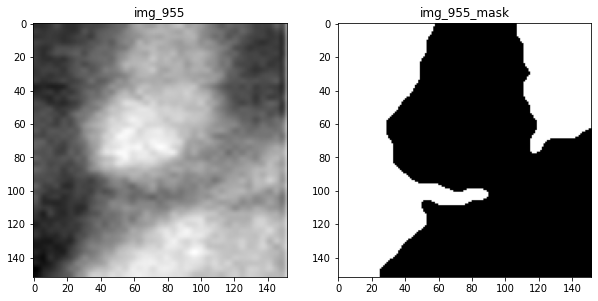

In [16]:
target_size = (152*2, 152)

selected_path = '../original_data/refined_labels_unselected/'
img_path = '../original_data/refined_labels_unselected_split/imgs/'
mask_path = '../original_data/refined_labels_unselected_split/masks/'

files = os.listdir(selected_path)
file = files[5]
index = file[6:-4] # original bmp file number    

image = Image.open(os.path.join(selected_path, file))       
resized_image = image.resize(target_size)
image.close()

# Get the dimensions of the image
width, height = resized_image.size

# Calculate the coordinates for cutting the image in half
left, top, right, bottom = 0, 0, width//2, height

# Crop the left half of the image
left_half = resized_image.crop((left, top, right, bottom)).convert('RGB')

# Calculate the coordinates for the right half of the image
left, right = width // 2, width

# Crop the right half of the image
right_half = resized_image.crop((left, top, right, bottom))

# Invert and conver to binary
right_half = 256 - np.array(right_half)[:, :, 0]
right_half = refine_label_gaussian(right_half, k_size=7, sigma=7, thsld=128, use_otsu=False)
right_half = Image.fromarray(right_half)

#visualize if the label is adapted what we want
fig,axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].imshow(left_half, cmap=cm.gray)
axs[0].set_title(f"img_{index}")
axs[1].imshow(right_half, cmap=cm.binary)
axs[1].set_title(f"img_{index}_mask")

Text(0.5, 1.0, 'img_947_mask')

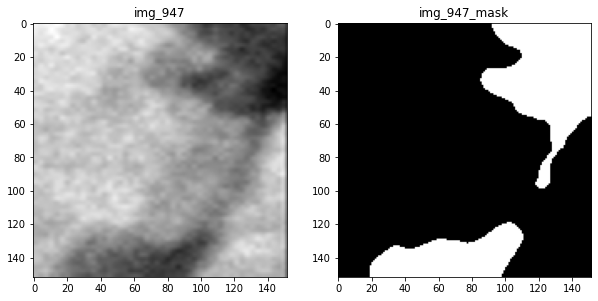

In [17]:
save_result = True

selected_path = '../original_data/refined_labels_unselected/'
img_path = '../original_data/refined_labels_unselected_split/imgs/'
mask_path = '../original_data/refined_labels_unselected_split/masks/'

target_size = (152*2, 152)

files = os.listdir(selected_path)

for file in files:
    index = file[6:-4] # original bmp file number    

    with Image.open(os.path.join(selected_path, file)) as image:     
        
        # resize image so that all the images are identical size (need for Unet batch norm)
        resized_image = image.resize(target_size)
        
        # Get the dimensions of the image
        width, height = resized_image.size

        # Calculate the coordinates for cutting the image in half
        left, top, right, bottom = 0, 0, width//2, height

        # Crop the left half of the image
        left_half = resized_image.crop((left, top, right, bottom)).convert('RGB')

        # Calculate the coordinates for the right half of the image
        left, right = width // 2, width

        # Crop the right half of the image
        right_half = resized_image.crop((left, top, right, bottom))

        # Invert and conver to binary
        right_half = 256 - np.array(right_half)[:, :, 0]
        right_half = refine_label_gaussian(right_half, k_size=7, sigma=7, thsld=128, use_otsu=False)
        right_half = Image.fromarray(right_half)

        # Save the left half as a new file
        left_half.save(img_path + f'img_{index}.png')

        # Save the right half as a new file
        right_half.save(mask_path + f'img_{index}_mask.png')
    
#visualize if the label is adapted what we want
fig,axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].imshow(left_half, cmap=cm.gray)
axs[0].set_title(f"img_{index}")
axs[1].imshow(right_half, cmap=cm.gray)
axs[1].set_title(f"img_{index}_mask")